### Description (ENG)

We have A/A test data from '2023-08-22' to '2023-08-28'. You need to do a simulation as if we ran 10,000 A/A tests. At each iteration, you need to form subsamples without repetition of 500 users from experimental groups 2 and 3. Compare these subsamples with a t-test.

**Task:**

1. Plot a histogram of the distribution of the resulting 10,000 p-values.

2. Calculate what percentage of p-values was less than or equal to 0.05.

3. Write a conclusion based on the A/A test performed, whether our splitting system works correctly.

### Description (RUS)

У нас есть данные А/А-теста с '2023-08-22' по '2023-08-28'. Вам нужно сделать симуляцию, как будто мы провели 10000 А/А-тестов. На каждой итерации вам нужно сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом.

**Задание:**

1. Построить гистограмму распределения получившихся 10000 p-values.

2. Посчитать, какой процент p values оказался меньше либо равен 0.05

3. Написать вывод по проведенному А/А-тесту, корректно ли работает наша система сплитования.

In [2]:
import pandas as pd
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
sns.set_style('darkgrid')

In [3]:
import swifter # to accelerate .apply() method
from scipy import stats

import pandahouse 

In [4]:
# Connection parameters to access ClickHouse DB
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20230920'} 

In [5]:
# Query to select data for 2, 3 experimental group at the corresponding dates
q = """
SELECT exp_group, user_id, sum(action = 'like') / sum(action = 'view') as ctr
FROM {db}.feed_actions
WHERE toDate(time) >= '2023-08-22' AND toDate(time) <= '2023-08-28' AND exp_group IN (2, 3)
GROUP BY exp_group, user_id
"""

In [6]:
df_users = pandahouse.read_clickhouse(q, connection=connection)

In [7]:
df_users.head(3)

,exp_group,user_id,ctr
0,3,115383,0.153226
1,3,10326,0.181818
2,3,123580,0.204918


In [8]:
# Let's form dataframes for 2 and 3 experimental groups
group_2 = df_users[df_users.exp_group == 2]
group_3 = df_users[df_users.exp_group == 3]

In [9]:
p_values = []

for i in range(0, 10000):
    p_value = stats.ttest_ind(group_2.sample(n=500, replace=False).ctr, 
                              group_3.sample(n=500, replace=False).ctr, 
                              equal_var=False)[1]
    p_values.append(p_value)

**Let's plot a histogram of the distribution of the resulting p-values:**

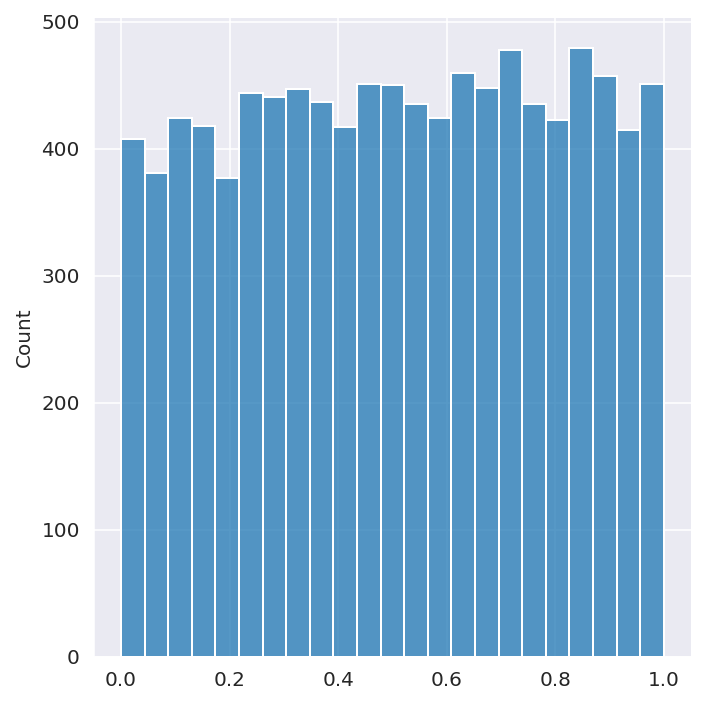

In [10]:
sns.displot(p_values)

In [11]:
# Percentage of p-value less or equal than 0.05
len(list(filter(lambda x: x <= 0.05, p_values)))/1e4

0.0474

### Results

Thus, when running the AA-test 10,000 times, the null hypothesis is rejected approximately 5% of the time (4.74%) $\Rightarrow$ the splitting system works correctly.